In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Load Datasets

In [8]:
d = datasets.load_digits(as_frame=True)
digits = d['data']
digits_target = d['target']

c = datasets.fetch_openml(name='credit-g', as_frame=True)
credit = c['data']
credit_target = c['target']

digits, digits_test, digits_target, digits_target_test = train_test_split(digits, digits_target, test_size = 0.2, random_state = 0)

credit, credit_test, credit_target, credit_target_test = train_test_split(credit, credit_target, test_size = 0.2, random_state = 0)

print (digits)


      pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
1109        0.0        0.0        0.0        9.0       15.0        2.0   
940         0.0        3.0       12.0       12.0       14.0        4.0   
192         0.0        1.0       10.0       15.0       16.0       13.0   
260         0.0        0.0        0.0       12.0        4.0        0.0   
1148        0.0        0.0        0.0        9.0       16.0        3.0   
...         ...        ...        ...        ...        ...        ...   
835         0.0        1.0        8.0       14.0       15.0        2.0   
1216        0.0        2.0        9.0       15.0       16.0       15.0   
1653        0.0        0.0        5.0       14.0       14.0        2.0   
559         0.0        0.0        4.0       10.0       15.0       16.0   
684         0.0        0.0        6.0       14.0       13.0        4.0   

      pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_6  pixel_6_7  \
1109        0.0        0.0      

## Preprocess Digits

In [9]:
# no preprocessing needed 

digits_final = pd.concat([digits, digits_target], axis=1)
digits_final.reset_index(drop=True, inplace=True)
print (digits_final)

digits_test_final = pd.concat([digits_test, digits_target_test], axis=1)
digits_test_final.reset_index(drop=True, inplace=True)
print (digits_test_final)

      pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
0           0.0        0.0        0.0        9.0       15.0        2.0   
1           0.0        3.0       12.0       12.0       14.0        4.0   
2           0.0        1.0       10.0       15.0       16.0       13.0   
3           0.0        0.0        0.0       12.0        4.0        0.0   
4           0.0        0.0        0.0        9.0       16.0        3.0   
...         ...        ...        ...        ...        ...        ...   
1432        0.0        1.0        8.0       14.0       15.0        2.0   
1433        0.0        2.0        9.0       15.0       16.0       15.0   
1434        0.0        0.0        5.0       14.0       14.0        2.0   
1435        0.0        0.0        4.0       10.0       15.0       16.0   
1436        0.0        0.0        6.0       14.0       13.0        4.0   

      pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_7  pixel_7_0  \
0           0.0        0.0      

## Preprocess Credit

In [10]:
#everything good with data except categorical to one hot needed 
credit_cat = ['checking_status', 'purpose', 'credit_history', 'savings_status', 'employment', 'personal_status', 'other_parties',
             'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'class']

def extract_columns (df, cols):
    return df.loc[:, cols]

def get_onehot (df, cat_feat):
    categories = extract_columns(df, cat_feat)
    le = LabelEncoder()
    return categories.apply(lambda col: le.fit_transform(col))

merged_credit = pd.concat([credit, credit_target], axis=1)
merged_credit.reset_index(drop=True, inplace=True)

merged_credit_test = pd.concat([credit_test, credit_target_test], axis=1)
merged_credit_test.reset_index(drop=True, inplace=True)

one_hot_cols = get_onehot(merged_credit, credit_cat)
credit_no_cat = merged_credit.drop(credit_cat, axis = 1) 
credit_no_cat = credit_no_cat.transform(lambda x: x if (np.amax(x) == 0) else (x / np.amax(x))) #normalize continuous data
credit_final = pd.concat([credit_no_cat, one_hot_cols], axis=1)


one_hot_cols_test = get_onehot(merged_credit_test, credit_cat)
credit_test_no_cat = merged_credit_test.drop(credit_cat, axis=1)
credit_test_no_cat = credit_test_no_cat.transform(lambda x: x if (np.amax(x) == 0) else (x / np.amax(x)))
credit_test_final = pd.concat([credit_test_no_cat, one_hot_cols_test], axis=1)

#le = LabelEncoder()

#credit_target = le.fit_transform(credit_target)
#credit_target_test = le.fit_transform(credit_target_test)

print (credit_final)
print (credit_test_final)



     duration  credit_amount  installment_commitment  residence_since  \
0    0.500000       0.155341                    1.00             0.75   
1    0.333333       0.169507                    1.00             0.25   
2    0.833333       0.402084                    1.00             0.50   
3    0.208333       0.068606                    0.50             0.50   
4    0.083333       0.084347                    0.25             0.50   
..        ...            ...                     ...              ...   
795  0.166667       0.058728                    1.00             1.00   
796  0.375000       0.212495                    1.00             0.50   
797  0.125000       0.207990                    0.25             1.00   
798  0.250000       0.104646                    0.50             0.50   
799  0.500000       0.535009                    0.25             0.75   

          age  existing_credits  num_dependents  checking_status  purpose  \
0    0.400000              0.25             0.

In [11]:
"""
Optimizer class implementing minibatch gradient descent for softmax regression. Can utilize either
    gradient descent with momentum, or Adaptive Momentum Estimation (Adam), with optional L1 or L2
    regularization.
"""
# Imports
import numpy as np
from sklearn.utils import shuffle


def softmax(z):
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T


# Shuffles the (x,y) instances, and outputs a list of minibatch_size sized (x,y) tuples
def minibatch(x, y, minibatch_size):
    x, y = shuffle(x, y)
    minibatches = []
    if not minibatch_size:
        minibatches.append((x, y))
    else:
        for i in range(0, x.shape[0], minibatch_size):
            x_mini = x[i:i+minibatch_size]
            y_mini = y[i:i+minibatch_size]
            minibatches.append((x_mini, y_mini))
    return minibatches


# Accuracy function
def accuracy(y, yh):
    pred = np.argmax(yh, axis=1)
    y_int = y.astype(np.int64)
    return np.mean(np.equal(pred, y_int))


# Returns the index of the maximum value in a list
def argmax(lst):
    return lst.index(max(lst))


class GradientDescent:

    """
    Class fields:
       alphaa - learning rate of the optimizer
       beta1 - momentum hyperparameter
       max_iterations - gradient descent termination condition: maximum times iterated
       max_no_change - gradient descent termination condition: maximum number of iterations
                         without the validation error decreasing
       minibatch_size - size of the minibatch to use (default value of 0 indicates use full batch)
       cost_fn - optional cost function, if included optimizer will calculate and store the
                    training and validation cost at each iteration
       adaptive - if true, optimizer uses Adam (Adaptive Moment Estimation) rather than gradient
                    descent with momentum
       beta2 - 2nd hyperparameter for Adam (if using)
       epsilon - 3rd hyperparameter for Adam (if using), just to avoid numerical issues
       regularize - determines regularization used (if any): 0 indicates no regularization, 1 or 2
                      indicate L1 or L2 regularization respectively
       lambdaa - regularization coefficient if used
    """
    # Constructor
    def __init__(self, alphaa=0.01, beta1=0.9, max_iterations=1e4, max_no_change=20, minibatch_size=0,
                 cost_fn=None, adaptive=False, beta2=0.999, epsilon=1e-8, regularize=0, lambdaa=0.1):

        self.alphaa = alphaa
        self.beta1 = beta1
        self.max_iterations = max_iterations
        self.max_no_change = max_no_change
        self.minibatch_size = minibatch_size
        self.cost_fn = cost_fn

        self.adaptive = adaptive
        self.beta2 = beta2
        self.epsilon = epsilon

        self.regularize = regularize
        self.lambdaa = lambdaa

        self.accuracy_tr = []
        self.accuracy_val = []
        self.weight_history = []
        if self.cost_fn:
            self.cost_tr = []
            self.cost_val = []

    # Run method - delegates work to one of 2 helper methods, dependent on if Adam is being used or not
    def run(self, x_tr, y_tr, x_val, y_val, w):
        if self.adaptive:
            return self.adam(x_tr, y_tr, x_val, y_val, w)
        else:
            return self.momentum(x_tr, y_tr, x_val, y_val, w)

    # Gradient Descent with Momentum
    def momentum(self, x_tr, y_tr, x_val, y_val, w):
        t = 1
        i = 0
        delta_w = 0

        self.accuracy_tr.append(accuracy(y_tr, softmax(np.dot(x_tr, w))))
        self.accuracy_val.append(accuracy(y_val, softmax(np.dot(x_val, w))))

        while i < self.max_no_change and t < self.max_iterations:
            for (x_mini, y_mini) in minibatch(x_tr, y_tr, self.minibatch_size):
                grad = self.gradient(x_mini, y_mini, w)
                delta_w = (self.beta1 * delta_w) + ((1 - self.beta1) * grad)
                w -= self.alphaa * delta_w

            self.weight_history.append(w)
            tr_pred = softmax(np.dot(x_tr, w))
            pred = softmax(np.dot(x_val, w))
            self.accuracy_tr.append(accuracy(y_tr, tr_pred))
            self.accuracy_val.append(accuracy(y_val, pred))
            if self.cost_fn:
                self.cost_tr.append(self.cost_fn(y_tr, tr_pred))
                self.cost_val.append(self.cost_fn(y_val, pred))

            if not self.accuracy_val[-1] < self.accuracy_val[-2]:
                i += 1
            else:
                i = 0
            t += 1

        return self.weight_history[argmax(self.accuracy_val)]

    # Adaptive Moment Estimation
    def adam(self, x_tr, y_tr, x_val, y_val, w):
        t = 1
        i = 0
        m = 0
        s = 0

        self.accuracy_tr.append(accuracy(y_tr, softmax(np.dot(x_tr, w))))
        self.accuracy_val.append(accuracy(y_val, softmax(np.dot(x_val, w))))

        while i < self.max_no_change and t < self.max_iterations:
            for (x_mini, y_mini) in minibatch(x_tr, y_tr, self.minibatch_size):
                grad = self.gradient(x_mini, y_mini, w)
                m = (self.beta1 * m) + ((1 - self.beta1) * grad)
                s = (self.beta2 * s) + ((1 - self.beta2) * np.power(grad, 2))
                mh = m / (1 - np.power(self.beta1, t))
                sh = s / (1 - np.power(self.beta2, t))
                w -= self.alphaa * mh * grad / (np.sqrt(sh) + self.epsilon)

            self.weight_history.append(w)
            tr_pred = softmax(np.dot(x_tr, w))
            pred = softmax(np.dot(x_val, w))
            self.accuracy_tr.append(accuracy(y_tr, tr_pred))
            self.accuracy_val.append(accuracy(y_val, pred))
            if self.cost_fn:
                self.cost_tr.append(self.cost_fn(y_tr, tr_pred))
                self.cost_val.append(self.cost_fn(y_val, pred))

            if not self.accuracy_val[-1] < self.accuracy_val[-2]:
                i += 1
            else:
                i = 0
            t += 1

        return self.weight_history[argmax(self.accuracy_val)]

    # Helper method to calculate gradient (and add regularization penalty if any)
    def gradient(self, x, y, w):
        n, d = x.shape
        yh = softmax(np.dot(x, w))

        grad = np.dot(x.T, yh - y) / n
        if self.regularize == 1:
            grad[1:] += self.lambdaa * np.sign(w[1:])
        elif self.regularize == 2:
            grad[1:] += self.lambdaa * w[1:]
        return grad

In [16]:
#from .._base import _BaseClassifier
#from .._base import _BaseMultiClass


class SoftmaxRegression(object):

    """Softmax regression classifier.

    """
    def __init__(self, learning_rate=0.01, max_iters=50,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):

        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.l2 = l2
        self.minibatches = minibatches
        self.n_classes = n_classes
        self.random_seed = random_seed


    def fit(self, X, y, gd):
        
        if self.random_seed is not None:
            np.random.seed(self.random_seed)
  
        if self.n_classes is None:
            self.n_classes = np.max(y) + 1
        self._n_features = X.shape[1]


        """Initialize weight coefficients."""
        np.random.seed(self.random_seed)
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=(self._n_features, self.n_classes)).astype('float64')
        self.cost_ = []

        y_enc = self._one_hot(y=y, n_labels=self.n_classes, dtype=np.float)
     
        for i in range(self.max_iters):
           
            
            #GRADIENT DESCENT line below (make sure to split X, y into training and validation sets)
            
            self._w = gd.run(X,y_enc,X,y_enc,self.w_)
            
            #COMMENT THE FOR LOOP BELOW

            """ 
            for idx in self._yield_minibatches_idx(
                    n_batches=self.minibatches,
                    data_ary=y,
                    shuffle=True):
                # givens:
                # w_ -> n_feat x n_classes
                # b_  -> n_classes
                
                # net_input, softmax and diff -> n_samples x n_classes:
                net = X[idx].dot(self.w_) #net_input
                softm = self.softmax(net) 
                diff = softm - y_enc[idx]
                mse = np.mean(diff, axis=0)

                # gradient -> n_features x n_classes
                grad = np.dot(X[idx].T, diff)
                
                # update in opp. direction of the cost gradient
                self.w_ -= (self.eta * grad +
                            self.eta * self.l2 * self.w_)  
            
            """  
            # compute cost of the whole epoch
            net = X.dot(self.w_)
            softm = self.softmax(net)
            cross_ent = self.cross_entropy(output=softm, y_target=y_enc)
            cost = self.cost(cross_ent)
            self.cost_.append(cost)
        
        return self

    def predict(self, X):
        #Predict targets from X.

        net = X.dot(self.w_)
        probas = self.softmax(net)
        return probas.argmax(axis=1)

    def softmax(self, z):
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T


    def cross_entropy(self, output, y_target):
        return - np.sum(np.log(output) * (y_target), axis=1)

    def cost(self, cross_entropy):
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        cross_entropy = cross_entropy + L2_term
        return 0.5 * np.mean(cross_entropy)


    def _one_hot(self, y, n_labels, dtype):
        mat = np.zeros((len(y), n_labels))
        for i, val in enumerate(y):
            mat[i, val] = 1
        return mat.astype(dtype)    
    
    def _yield_minibatches_idx(self, n_batches, data_ary, shuffle=True):
            indices = np.arange(data_ary.shape[0])

            if shuffle:
                indices = np.random.permutation(indices)
            if n_batches > 1:
                remainder = data_ary.shape[0] % n_batches

                if remainder:
                    minis = np.array_split(indices[:-remainder], n_batches)
                    minis[-1] = np.concatenate((minis[-1],
                                                indices[-remainder:]),
                                               axis=0)
                else:
                    minis = np.array_split(indices, n_batches)

            else:
                minis = (indices,)

            for idx_batch in minis:
                yield idx_batch
    

       0    1     2     3     4     5    6    7    8     9   ...    54   55  \
0     0.0  0.0   0.0   9.0  15.0   2.0  0.0  0.0  0.0   0.0  ...  15.0  6.0   
1     0.0  3.0  12.0  12.0  14.0   4.0  0.0  0.0  0.0   1.0  ...   8.0  0.0   
2     0.0  1.0  10.0  15.0  16.0  13.0  3.0  0.0  0.0   5.0  ...   0.0  0.0   
3     0.0  0.0   0.0  12.0   4.0   0.0  0.0  0.0  0.0   0.0  ...   0.0  0.0   
4     0.0  0.0   0.0   9.0  16.0   3.0  0.0  0.0  0.0   0.0  ...   0.0  0.0   
...   ...  ...   ...   ...   ...   ...  ...  ...  ...   ...  ...   ...  ...   
1432  0.0  1.0   8.0  14.0  15.0   2.0  0.0  0.0  0.0   2.0  ...   1.0  0.0   
1433  0.0  2.0   9.0  15.0  16.0  15.0  2.0  0.0  0.0  11.0  ...   7.0  0.0   
1434  0.0  0.0   5.0  14.0  14.0   2.0  0.0  0.0  0.0   2.0  ...   0.0  0.0   
1435  0.0  0.0   4.0  10.0  15.0  16.0  4.0  0.0  0.0   0.0  ...   0.0  0.0   
1436  0.0  0.0   6.0  14.0  13.0   4.0  0.0  0.0  0.0   4.0  ...   1.0  0.0   

       56   57    58    59    60    61    62   63  

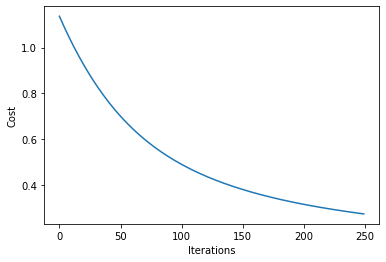

In [15]:


# Loading Data

#X = one_hot_cols.values
#y = credit_target.values

X = digits.values
y = digits_target.values


df = pd.DataFrame(X)
print (df)
df = df.transform(lambda x: x if (np.amax(x) == 0) else (x / np.amax(x)))

print (df)
#standardize
# X[:,0] = X[:,0] / np.amax(X[:,0])
# X[:,1] = X[:,1] / np.amax(X[:,1])

print (y)

lr = SoftmaxRegression(learning_rate=0.00001, max_iters=250, minibatches=1, random_seed=0)
gd = GradientDescent()
lr.fit(df.to_numpy(), y, gd)

# #X_plt = X[:, [0,1]]

# #plot_decision_regions(X_plt, y, clf=lr)
# #plt.title('Softmax Regression - Gradient Descent')
# #plt.show()

plt.plot(range(len(lr.cost_)), lr.cost_)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [9]:
digits_target_test.values[0:]

array([2, 8, 2, 6, 6, 7, 1, 9, 8, 5, 2, 8, 6, 6, 6, 6, 1, 0, 5, 8, 8, 7,
       8, 4, 7, 5, 4, 9, 2, 9, 4, 7, 6, 8, 9, 4, 3, 1, 0, 1, 8, 6, 7, 7,
       1, 0, 7, 6, 2, 1, 9, 6, 7, 9, 0, 0, 5, 1, 6, 3, 0, 2, 3, 4, 1, 9,
       2, 6, 9, 1, 8, 3, 5, 1, 2, 8, 2, 2, 9, 7, 2, 3, 6, 0, 5, 3, 7, 5,
       1, 2, 9, 9, 3, 1, 7, 7, 4, 8, 5, 8, 5, 5, 2, 5, 9, 0, 7, 1, 4, 7,
       3, 4, 8, 9, 7, 9, 8, 2, 6, 5, 2, 5, 8, 4, 8, 7, 0, 6, 1, 5, 9, 9,
       9, 5, 9, 9, 5, 7, 5, 6, 2, 8, 6, 9, 6, 1, 5, 1, 5, 9, 9, 1, 5, 3,
       6, 1, 8, 9, 8, 7, 6, 7, 6, 5, 6, 0, 8, 8, 9, 8, 6, 1, 0, 4, 1, 6,
       3, 8, 6, 7, 4, 5, 6, 3, 0, 3, 3, 3, 0, 7, 7, 5, 7, 8, 0, 7, 8, 9,
       6, 4, 5, 0, 1, 4, 6, 4, 3, 3, 0, 9, 5, 9, 2, 1, 4, 2, 1, 6, 8, 9,
       2, 4, 9, 3, 7, 6, 2, 3, 3, 1, 6, 9, 3, 6, 3, 2, 2, 0, 7, 6, 1, 1,
       9, 7, 2, 7, 8, 5, 5, 7, 5, 2, 3, 7, 2, 7, 5, 5, 7, 0, 9, 1, 6, 5,
       9, 7, 4, 3, 8, 0, 3, 6, 4, 6, 3, 2, 6, 8, 8, 8, 4, 6, 7, 5, 2, 4,
       5, 3, 2, 4, 6, 9, 4, 5, 4, 3, 4, 6, 2, 9, 0,

In [10]:

y_pred = lr.predict(digits_test.values)
print('Last 2 Class Labels: %s' % y_pred[0:])



Last 2 Class Labels: [2 8 2 6 6 7 1 9 8 5 2 8 6 6 6 6 1 0 5 8 8 7 8 4 7 5 4 9 2 9 4 7 6 8 9 4 3
 1 0 1 8 6 7 7 9 0 7 6 2 1 9 6 7 9 0 0 9 1 6 3 0 2 3 4 1 9 7 6 9 1 8 3 5 1
 2 1 2 2 9 7 2 3 6 0 5 3 7 5 1 2 9 9 3 1 7 7 4 8 5 8 5 5 2 5 9 0 7 1 4 7 3
 4 8 9 7 7 8 0 1 9 2 5 8 4 1 7 0 6 1 5 9 9 9 5 9 9 5 7 5 6 2 8 6 9 6 1 5 1
 5 9 9 1 5 3 6 1 8 9 7 7 6 7 6 5 6 0 8 8 9 3 6 1 0 7 1 6 3 8 6 7 4 9 6 3 0
 3 3 3 0 7 7 5 7 8 0 7 8 9 6 4 5 0 1 4 6 4 3 3 0 9 5 9 3 9 4 7 1 6 8 9 2 4
 9 3 7 6 2 3 3 1 6 9 3 6 3 3 2 0 7 6 1 1 3 7 2 7 1 5 5 7 5 2 2 7 2 7 5 5 7
 0 9 1 6 5 9 7 4 3 8 0 3 6 4 6 3 2 6 8 8 8 4 6 7 5 2 4 5 3 2 4 6 9 4 5 4 3
 4 6 2 9 0 6 7 2 0 9 6 0 4 2 0 7 5 8 5 7 8 2 8 4 3 7 2 6 5 9 5 1 0 8 2 5 9
 5 6 8 2 7 2 1 5 1 6 4 5 0 9 4 1 1 7 0 8 9 0 5 4 8 8 8]


[[0.5        0.15534086 1.         ... 1.         0.         1.        ]
 [0.33333333 0.16950716 1.         ... 1.         0.         1.        ]
 [0.83333333 0.40208424 1.         ... 0.         0.         1.        ]
 ...
 [0.125      0.20798958 0.25       ... 3.         0.         1.        ]
 [0.25       0.10464611 0.5        ... 3.         0.         1.        ]
 [0.5        0.53500868 0.25       ... 3.         1.         1.        ]]
     duration  credit_amount  installment_commitment  residence_since  \
0    0.500000       0.155341                    1.00             0.75   
1    0.333333       0.169507                    1.00             0.25   
2    0.833333       0.402084                    1.00             0.50   
3    0.208333       0.068606                    0.50             0.50   
4    0.083333       0.084347                    0.25             0.50   
..        ...            ...                     ...              ...   
795  0.166667       0.058728                 

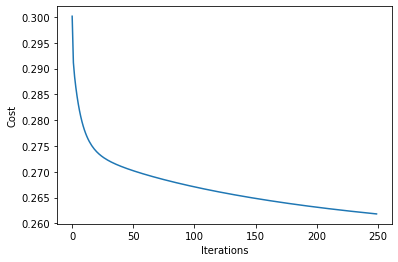

In [11]:

# Loading Data

x_train = credit_final.loc[:,credit_final.columns != "class"]
y_train = credit_final.loc[:,credit_final.columns == "class"]

print (x_train.to_numpy())

# df = pd.DataFrame(x_train)
# df = df.transform(lambda x: x if (np.amax(x) == 0) else (x / np.amax(x)))

lr2 = SoftmaxRegression(learning_rate=0.00001, max_iters=250, minibatches=1, random_seed=0)
gd = GradientDescent()
lr2.fit(x_train.to_numpy(), y_train.values.ravel(), gd)

print (x_train)
#X_plt = X[:, [0,1]]

#plot_decision_regions(X_plt, y, clf=lr)
#plt.title('Softmax Regression - Gradient Descent')
#plt.show()

plt.plot(range(len(lr2.cost_)), lr2.cost_)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [12]:
credit_target_test[-10:]

834     bad
832     bad
435     bad
5      good
769    good
679    good
722     bad
215    good
653     bad
150    good
Name: class, dtype: category
Categories (2, object): [good, bad]

In [611]:
y_pred = lr2.predict(one_hot_cols_test.values)
print('Last 2 Class Labels: %s' % y_pred[-100:])
len(y_pred)


Last 2 Class Labels: [0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1]


200

# Analysis

## Cross-Validation Class

In [42]:
class Cross_Validation:
    def cross_validate(self, data, k, model, gradient_obj, test_cols): 
        
        train_col = None
        
        for c in test_cols:
            if c in data:
                train_col = c
                break
        
        shuffled_data = data.sample(frac=1, random_state=0).reset_index(drop=True)
            
        folds = np.array_split(shuffled_data, k)
        
        accuracy_sum = 0
        
        for i in range(k):
            folds_to_train = folds.copy()
            fold_to_test = folds_to_train[i]
            del folds_to_train[i]
            folds_to_train = pd.concat(folds_to_train, sort=False)
            
            x_train = folds_to_train.loc[:,folds_to_train.columns != train_col]
            y_train = folds_to_train.loc[:,folds_to_train.columns == train_col]
            
            x_test = fold_to_test.loc[:,fold_to_test.columns != train_col]
            y_test = fold_to_test.loc[:,fold_to_test.columns == train_col]
            
            model.fit(x_train, y_train.values.ravel(), gradient_obj)
            predictions = model.predict(x_test.to_numpy())
            accuracy_sum += accuracy_score(predictions, y_test.values.ravel())
            
        return accuracy_sum / k

cross = Cross_Validation()

In [ ]:
# set up grid testing

    
param_grid = [
  {'learning_rate': np.arange(0.00001, 0.0001, 0.00005), 'max_iters': [250], 'random_seed':[0],
  'alphaa': np.arange(0.001, 0.011, 0.01), 'beta1': np.arange(0.9, 0.99, 0.09), 'max_iterations': [1e4], 'max_no_change': np.arange(10,20,10), 
  'adaptive': [False], 'beta2': np.arange(0.99, 0.999, 0.009), 'epsilon': np.arange(1e-9, 1e-8, 9e-9), 'minibatch_size': np.arange(1,10, 9),
  'regularize': [0,1,2], 'lambdaa': np.arange(0.01, 0.1, 0.09)}
]


#merge train and train targets, send to cross validation for each grid
print (digits_final)
print (credit_final)

class Tester:
    def __init__(self, learning_rate=0.01, max_iters=50, random_seed=0, alphaa=0.001, beta1=0.9, max_iterations=1e4, max_no_change=20,
                 adaptive=False, beta2=0.999, epsilon=1e-8, minibatch_size=0, regularize=0, lambdaa=0.1):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.random_seed = random_seed
        self.alphaa = alphaa
        self.beta1 = beta1
        self.max_iterations = max_iterations
        self.max_no_change = max_no_change
        self.adaptive = adaptive
        self.beta2 = beta2
        self.epsilon = epsilon
        self.regularize = regularize
        self.lambdaa = lambdaa
        self.minibatch_size = minibatch_size
        
    
    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        params = {'learning_rate': self.learning_rate, 'max_iters': self.max_iters, 'random_seed':self.random_seed,
                  'alphaa': self.alphaa, 'beta1': self.beta1, 'max_iterations': self.max_iterations, 'max_no_change': self.max_no_change, 
                  'adaptive': self.adaptive, 'beta2':self.beta2, 'epsilon': self.epsilon, 'minibatch_size': self.minibatch_size,
                  'regularize': self.regularize, 'lambdaa': self.lambdaa}
        return params

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self,X):
        self.lr = SoftmaxRegression(learning_rate=self.learning_rate, max_iters=self.max_iters, random_seed=self.random_seed)
        self.gd = GradientDescent(alphaa=self.alphaa, max_iterations=self.max_iterations, max_no_change=self.max_no_change,
                                  adaptive=self.adaptive, beta2=self.beta2, epsilon=self.epsilon, regularize=self.regularize,
                                  lambdaa=self.lambdaa, minibatch_size=self.minibatch_size)
        self.accuracy = cross.cross_validate(X, 5, self.lr, self.gd, ['target', 'class'])
        print (self.accuracy)
        return self.accuracy
        
    
def test_scorer(estimator, X):
    print (estimator.accuracy)
    return estimator.accuracy

# def tester_scorer_credit(estimator, X):
#     error = cross.cross_validate(X, 5, estimator.lr, estimator.gd, 'class')
#     return error
    
cv = [(slice(None), slice(None))] # dont use grid search cross validation, want to use our own
gs = GridSearchCV(estimator=Tester(), param_grid=param_grid, 
                  scoring=test_scorer, cv=cv, n_jobs=-1)

gs.fit(digits_final)
#get best hyper parameters, then run test data using them



      pixel_0_0  pixel_0_1  pixel_0_2  pixel_0_3  pixel_0_4  pixel_0_5  \
0           0.0        0.0        0.0        9.0       15.0        2.0   
1           0.0        3.0       12.0       12.0       14.0        4.0   
2           0.0        1.0       10.0       15.0       16.0       13.0   
3           0.0        0.0        0.0       12.0        4.0        0.0   
4           0.0        0.0        0.0        9.0       16.0        3.0   
...         ...        ...        ...        ...        ...        ...   
1432        0.0        1.0        8.0       14.0       15.0        2.0   
1433        0.0        2.0        9.0       15.0       16.0       15.0   
1434        0.0        0.0        5.0       14.0       14.0        2.0   
1435        0.0        0.0        4.0       10.0       15.0       16.0   
1436        0.0        0.0        6.0       14.0       13.0        4.0   

      pixel_0_6  pixel_0_7  pixel_1_0  pixel_1_1  ...  pixel_6_7  pixel_7_0  \
0           0.0        0.0      

In [41]:
print (gs.cv_results_)
print (gs.best_params_)

{'mean_fit_time': array([77.75337529, 76.56331205]), 'std_fit_time': array([0., 0.]), 'mean_score_time': array([0., 0.]), 'std_score_time': array([0., 0.]), 'param_learning_rate': masked_array(data=[1e-05, 6e-05],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 1e-05}, {'learning_rate': 6e-05}], 'split0_test_score': array([0.94850707, 0.94850707]), 'mean_test_score': array([0.94850707, 0.94850707]), 'std_test_score': array([0., 0.]), 'rank_test_score': array([1, 1])}
{'learning_rate': 1e-05}
